In [1]:
import pandas as pd 
import wandb
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("leonsunwl/ntu-msds-sd6106")

summary_list, config_list, name_list = [], [], []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
          if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })

runs_df.to_csv("project.csv")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/leonsun/.netrc
wandb: Currently logged in as: leonsunwl to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
summary_df = pd.json_normalize(runs_df[9:]['summary'])


In [24]:
run_names_df = runs_df['name'].str.split('_',expand=True)
run_names_df.columns = ['model_name','strategy','','client','','round']

In [29]:
run_names_df = run_names_df.iloc[9:][['model_name','strategy','client','round']]

In [35]:
run_summary_df = pd.merge(left=run_names_df,right=summary_df,left_index=True, right_index=True)
run_summary_df.head()

,model_name,strategy,client,round,_runtime,_step,_timestamp,eval/R1,eval/R2,eval/RL,...,train/epoch,train/global_step,train/grad_norm,train/learning_rate,train/loss,train_loss,train_runtime,train_samples_per_second,train_steps_per_second,_wandb.runtime
9,Google-T5-Small,fedavg,1,1,467.782829,13,1.740815e+09,0.0273,0.0003,0.0271,...,2.97561,336,0.068885,1.456675e-06,0.2342,0.312806,439.0174,98.477,0.765,483
10,Google-T5-Small,fedavg,2,1,466.175410,13,1.740815e+09,0.0261,0.0001,0.0258,...,2.97561,336,0.067918,1.456675e-06,0.2334,0.311530,438.1040,98.682,0.767,481
11,Google-T5-Small,fedavg,0,1,466.864546,13,1.740816e+09,0.0259,0.0003,0.0255,...,2.97561,336,0.064275,1.456675e-06,0.2340,0.312898,438.2989,98.638,0.767,476
12,Google-T5-Small,fedavg,0,2,454.045310,13,1.740816e+09,0.1204,0.0082,0.1133,...,2.97561,336,0.037634,5.112834e-07,0.1831,0.197977,441.1517,98.000,0.762,456
13,Google-T5-Small,fedavg,1,2,452.431654,13,1.740817e+09,0.1146,0.0069,0.1087,...,2.97561,336,0.041600,5.112834e-07,0.1826,0.197864,439.6511,98.335,0.764,454


In [36]:
run_summary_df.columns

Index(['model_name', 'strategy', 'client', 'round', '_runtime', '_step',
       '_timestamp', 'eval/R1', 'eval/R2', 'eval/RL', 'eval/RLsum',
       'eval/loss', 'eval/runtime', 'eval/samples_per_second',
       'eval/steps_per_second', 'total_flos', 'train/epoch',
       'train/global_step', 'train/grad_norm', 'train/learning_rate',
       'train/loss', 'train_loss', 'train_runtime', 'train_samples_per_second',
       'train_steps_per_second', '_wandb.runtime'],
      dtype='object')

In [37]:
eval_metrics_df = run_summary_df[['strategy', 'round', 'eval/R1', 'eval/R2', 'eval/RL', 'eval/RLsum', 'eval/loss']]

In [38]:
eval_metrics_df.head()

,strategy,round,eval/R1,eval/R2,eval/RL,eval/RLsum,eval/loss
9,fedavg,1,0.0273,0.0003,0.0271,0.0271,0.244265
10,fedavg,1,0.0261,0.0001,0.0258,0.0258,0.244239
11,fedavg,1,0.0259,0.0003,0.0255,0.0255,0.240049
12,fedavg,2,0.1204,0.0082,0.1133,0.1130,0.177056
13,fedavg,2,0.1146,0.0069,0.1087,0.1087,0.180123


In [47]:
eval_metrics_df_melted = eval_metrics_df \
    .melt(id_vars=['strategy','round']) \
        .rename(columns={'variable':'metric'})
eval_metrics_df_melted.head()

,strategy,round,metric,value
0,fedavg,1,eval/R1,0.0273
1,fedavg,1,eval/R1,0.0261
2,fedavg,1,eval/R1,0.0259
3,fedavg,2,eval/R1,0.1204
4,fedavg,2,eval/R1,0.1146


In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

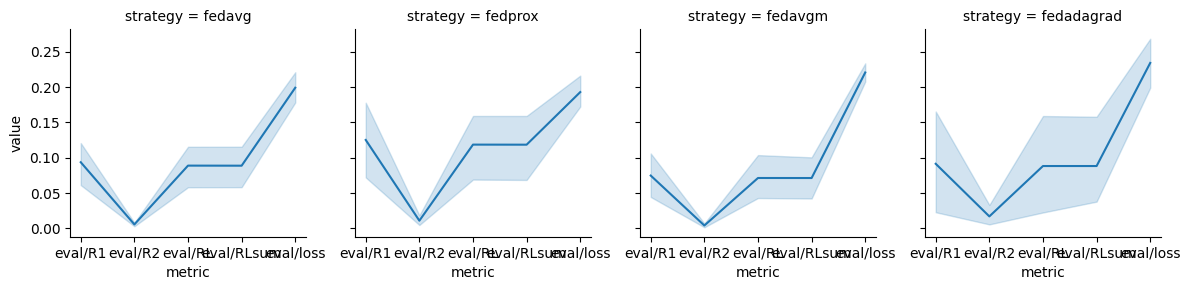

In [51]:
g = sns.FacetGrid(eval_metrics_df_melted,col='strategy')
g.map(sns.lineplot,'metric','value')